**XGBoost Algorithm**

In [42]:
#loading the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [28]:
# Loading the dataset
df = pd.read_csv('winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


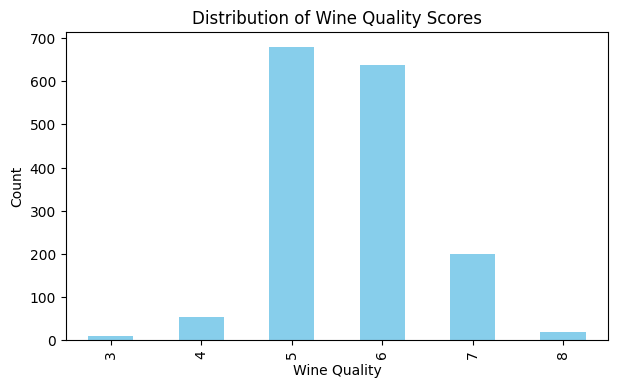

In [29]:
# PLot for visualization fo the target column

plt.figure(figsize=(7,4))
df['quality'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Wine Quality')
plt.ylabel('Count')
plt.title('Distribution of Wine Quality Scores')
plt.show()


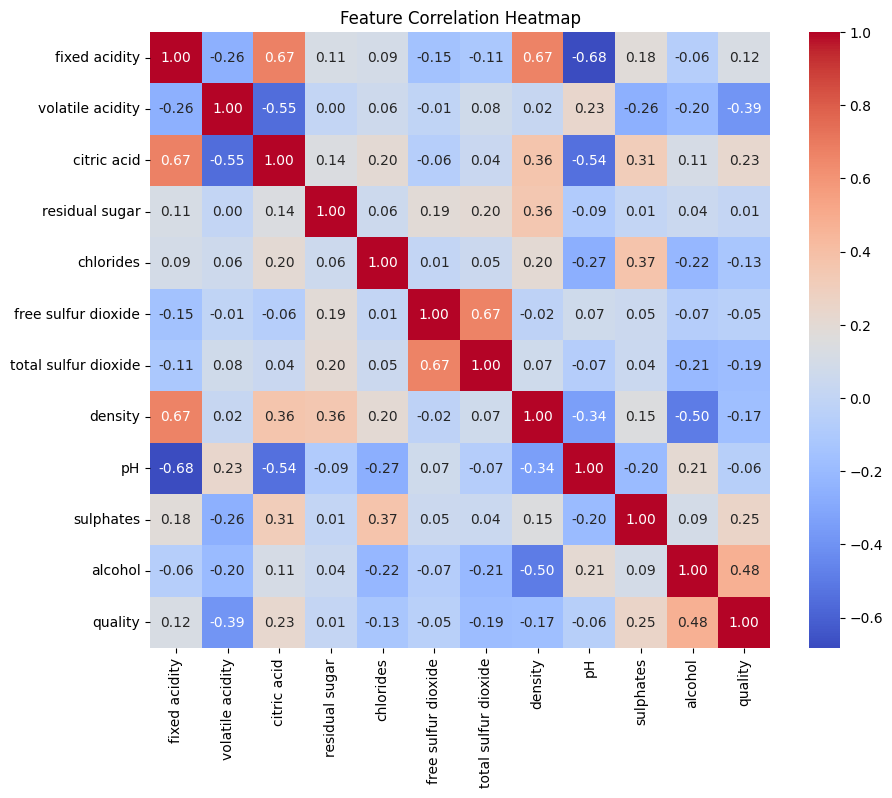

In [30]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


Obervation:
Here, in the heatmap, red color shoes positie correlation and blue show negative correlation.

1. `alcohol` (0.48) with `quality`—higher alcohol content tends to improve quality.

2. `volatile acidity` (-0.39) with `quality`—higher volatility reduces quality.

3. Moderate correlations: `density` (-0.50) with `pH`, `fixed acidity` (1.00) with itself (diagonal).

4. Weak correlations: `residual sugar` (0.01) with `quality`, indicating minimal impact.

**Dataset split using 'trin_test_split'**

In [31]:
# Seperatign the features (X) and target(y)
X = df.drop('quality', axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Suared Error Objective**

In [32]:
# Squared Error Objective
class SquaredErrorObjective:
    # Comuputing MSE Loss (avg squared differrecces between true and predicted vlaues)
    def loss(self, y, pred):
        return np.mean((y - pred) ** 2)
    # Comupting First derivative (gradient) of the MSE
    def gradient(self, y, pred):
        return pred - y
    # Computing Second Derivative (hessian) for the MSE
    # represnts the curvature of the  loss fucntion
    def hessian(self, y, pred):
        return np.ones(len(y))

**XGBoost Model**

Is is the main class for XGBoost Model where initialization handling, training and prediction is being done.

1. **Initializing**: the model is initialized with default parameters to handle missing keys.

'params' : handle missing keys
'subsample': ratio for row sampling
'learning rate': for scalign pooster prediciton

'base_prediction': base prediction for all samples

'max_depth': maximum depth for eah decison tree


2. **Trainig the model**: the model is trained by iteratively building boosters using the gradietns and hessians.

3. **Prediction of the model**: here prediction is done by combining the base prediction with all boosters.

In [50]:
# XGBoost model class
class XGBoostModel:
    # Initialising the model usin parameters
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(lambda: None, params)
        self.subsample = self.params['subsample'] if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)

    # Training the XGBoost model
    def fit(self, X, y, objective, num_boost_round, verbose=False):
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        self.boosters = []  # lsit to store sll booster(tree) models
        self.loss_history = []  # list to track loss at each boosting
        for i in range(num_boost_round):
            # computing gradient and Hessians
            gradients = objective.gradient(y, current_predictions)
            hessians = objective.hessian(y, current_predictions)
            sample_idxs = None if self.subsample == 1.0 \
                else self.rng.choice(len(y), size=math.floor(self.subsample*len(y)), replace=False)
            # building a new booster using the current gradeitns and hessian
            booster = TreeBooster(X, gradients, hessians, self.params, self.max_depth, sample_idxs)
            current_predictions += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            loss = objective.loss(y, current_predictions)
            self.loss_history.append(loss)
            if verbose:
                print(f'[{i}] train loss = {loss:.4f}')

    # Generating predictions by combining base with all boosters outputs
    def predict(self, X):
        return (self.base_prediction + self.learning_rate
                * np.sum([booster.predict(X) for booster in self.boosters], axis=0))

**Single Decision Tree Booster**



In [38]:
class TreeBooster:
     # Initialize booster with feature matrix (X), gradients (g), Hessians (h), parameters, and max depth
    def __init__(self, X, g, h, params, max_depth, idxs=None):
        self.params = params
        self.max_depth = max_depth
        assert self.max_depth >= 0, 'max_depth must be nonnegative'
        self.min_child_weight = params['min_child_weight'] if params['min_child_weight'] else 1.0
        # L2 Regulization parameter
        self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0
         # Minimum loss reduction required to split (default: 0.0)
        self.gamma = params['gamma'] if params['gamma'] else 0.0
        self.colsample_bynode = params['colsample_bynode'] if params['colsample_bynode'] else 1.0
        # Convert pandas Series to numpy arrays if necessary
        if isinstance(g, pd.Series): g = g.values
        if isinstance(h, pd.Series): h = h.values
        if idxs is None: idxs = np.arange(len(g))
        self.X, self.g, self.h, self.idxs = X, g, h, idxs
        self.n, self.c = len(idxs), X.shape[1]
        # Initial leaf value based on gradient and Hessian sums with regularization
        self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda)
        self.best_score_so_far = 0.
        if self.max_depth > 0:
            self._maybe_insert_child_nodes()

    # Child nodes insertion by evalauting the splits
    def _maybe_insert_child_nodes(self):
        for i in range(self.c): self._find_better_split(i)
        if self.is_leaf: return
        x = self.X.values[self.idxs, self.split_feature_idx]
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]
        # Recursively create left and right child boosters with reduced depth
        self.left = TreeBooster(self.X, self.g, self.h, self.params, self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params, self.max_depth - 1, self.idxs[right_idx])

    # Property to check is node is a leaf
    @property
    def is_leaf(self):
      return self.best_score_so_far == 0.

    # Finding the best split for the given features
    def _find_better_split(self, feature_idx):
        #feature values for current indices
        x = self.X.values[self.idxs, feature_idx]
        # Gradients and Hessians for current indices
        g, h = self.g[self.idxs], self.h[self.idxs]
        sort_idx = np.argsort(x)
        # Sorted arrays
        sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]
        # Total gradient and Hessian sums
        sum_g, sum_h = g.sum(), h.sum()
        sum_g_right, sum_h_right = sum_g, sum_h
        sum_g_left, sum_h_left = 0., 0.

        for i in range(0, self.n - 1):
            g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i + 1]
            # Update left and right gradient sums
            sum_g_left += g_i; sum_g_right -= g_i
            # Update left and right Hessian sums
            sum_h_left += h_i; sum_h_right -= h_i
            if sum_h_left < self.min_child_weight or x_i == x_i_next: continue
            if sum_h_right < self.min_child_weight: break
            # Calculate gain using similarity scores: (left + right - parent) - gamma/2
            gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda))
                          + (sum_g_right**2 / (sum_h_right + self.reg_lambda))
                          - (sum_g**2 / (sum_h + self.reg_lambda))
                          ) - self.gamma/2
            if gain > self.best_score_so_far:
                self.split_feature_idx = feature_idx
                self.best_score_so_far = gain
                self.threshold = (x_i + x_i_next) / 2

    # Generate predictions for input data X
    def predict(self, X):
        return np.array([self._predict_row(row) for i, row in X.iterrows()])
    # Predict value for a single row by traversing the tree
    def _predict_row(self, row):
        if self.is_leaf:
            return self.value
        child = self.left if row[self.split_feature_idx] <= self.threshold else self.right
        return child._predict_row(row)

**Training Model & Setting parameters**

In [51]:
# Defining Hyperparameters for the model
params = {
    'learning_rate': 0.1, # Step size for updating predictions
    'max_depth': 4,  # Maximum depth of each decision tree
    'subsample': 0.8,  # Fraction of rows to sample per boosting round
    'reg_lambda': 1.0, # L2 regularization parameter
    'gamma': 0.0,      # Minimum loss reduction required for a split
    'min_child_weight': 5, # Minimum sum of Hessians in a child node
    'base_score': y_train.mean(), # Initial prediction
}
num_boost_round = 20

In [52]:
# Training the XGBoost Model
# X_train: Feature matrix, y_train: Target values, SquaredErrorObjective: Loss function
model = XGBoostModel(params, random_seed=42)
model.fit(X_train, y_train, SquaredErrorObjective(), num_boost_round, verbose=True)

<ipython-input-38-872ff1c524bf>:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold else self.right


[0] train loss = 0.6031
[1] train loss = 0.5610
[2] train loss = 0.5247
[3] train loss = 0.4945
[4] train loss = 0.4682
[5] train loss = 0.4441
[6] train loss = 0.4269
[7] train loss = 0.4125
[8] train loss = 0.3963
[9] train loss = 0.3839
[10] train loss = 0.3715
[11] train loss = 0.3617
[12] train loss = 0.3524
[13] train loss = 0.3438
[14] train loss = 0.3369
[15] train loss = 0.3301
[16] train loss = 0.3236
[17] train loss = 0.3189
[18] train loss = 0.3136
[19] train loss = 0.3092


Observation:
The ouput represents the training loss (MSE) at each boosting round during the training of the model.

1.Initial Loss ([0] = 0.6031): Starts high, based on the base_score (mean of y_train) and initial predictions.

2. Trend: Decreases steadily (e.g., 0.6031 → 0.5610 → 0.3092), indicating the model is reducing error by fitting residuals with each tree.

3. Slows down after [10] (0.3715), suggesting diminishing returns as the model approaches the training data's complexity limit.

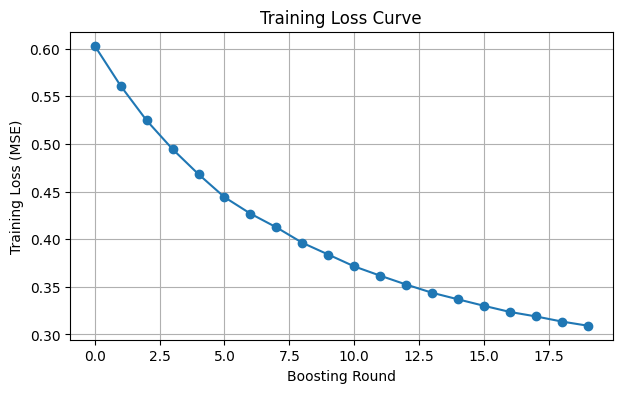

In [40]:
# Plotting the Training Loass Curve
plt.figure(figsize=(7,4))
plt.plot(model.loss_history, marker='o')
plt.xlabel('Boosting Round')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()

Obervation:
1. X-azis: Represents the number of trees added.
2. Y-axis (Training Loss (MSE): Shows the MSE, ranging from ~0.60 to ~0.30.

Confirms your XGBoost implementation is effective—loss reduces consistently, but the flattening suggests potential overfitting.

**Model Evaluation**

The purpost of the model evaluation is to calculate the RMSE on the test set after training the model.

**RMSE**: RMSE measures the square root of the average squared differences between predicted and actual values.

RMSE of 0.6161 means, on average, the model's predictions deviate by ~0.6161 units

In [44]:
# Model Evaluation
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.4f}")

<ipython-input-38-872ff1c524bf>:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  child = self.left if row[self.split_feature_idx] <= self.threshold else self.right


Test RMSE: 0.6161


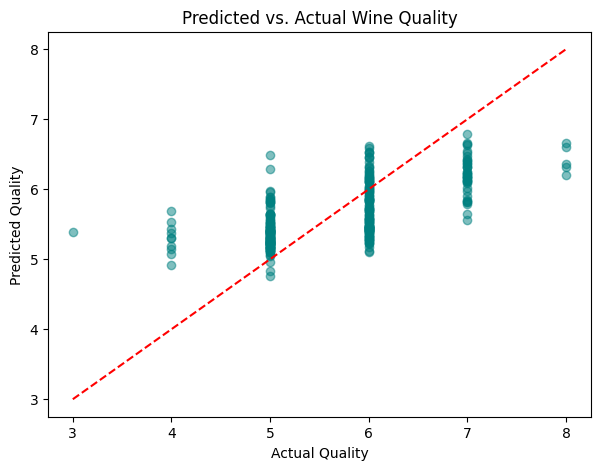

In [45]:
# Predicted vs. Actual Scatter Plot
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.5, color='teal')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.title('Predicted vs. Actual Wine Quality')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

Assesses how well the XGBoost model's predictions align with actual values, providing a visual evaluation of performance.

- **Scatter Plot**: Visualizes individual prediction accuracy.
- **Diagonal Line**: Represents perfect prediction (predicted = actual).
- **Prediction Error**: Deviation from the diagonal, quantified by RMSE.

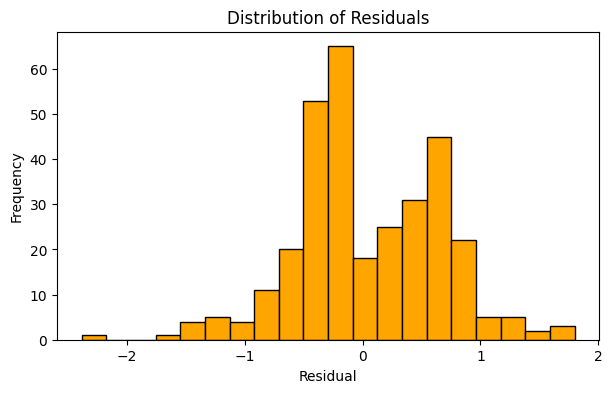

In [46]:
# Residuals Histogram
residuals = y_test - y_pred
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=20, color='orange', edgecolor='k')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

Observation:
Showing the errors (residuals) between the actual and predicted `quality` values on the test set from your XGBoost model on the dataset.

1. X-axis (Residual): Ranges from -2 to 2, showing prediction errors (negative = underprediction, positive = overprediction).

2. Y-axis (Frequency): Counts how often each residual value occurs

3. The distribution is roughly symmetric, centered near 0, with most residuals between -1 and 1.

4. Highest frequency (~60) near 0, indicating many predictions are close to actual values.

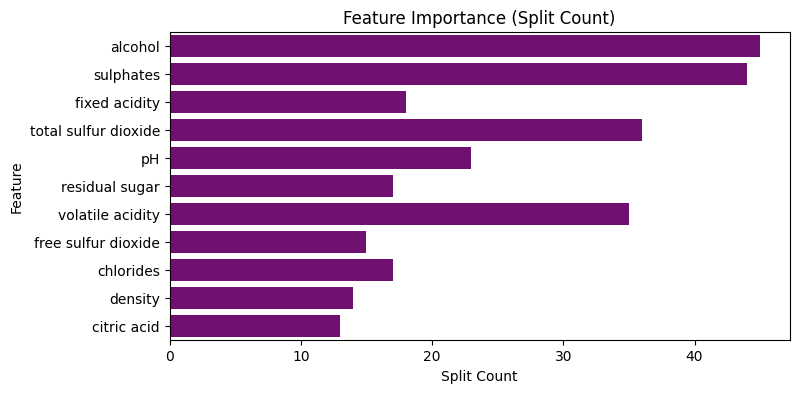

In [49]:
# Feature Importance Visualization
from collections import Counter
def get_feature_importance(model, feature_names):
    split_counts = Counter()
    for booster in model.boosters:
        stack = [booster]
        while stack:
            node = stack.pop()
            if hasattr(node, 'split_feature_idx'):
                split_counts[node.split_feature_idx] += 1
                if hasattr(node, 'left'):
                    stack.append(node.left)
                if hasattr(node, 'right'):
                    stack.append(node.right)
    return {feature_names[idx]: count for idx, count in split_counts.items()}

feature_importance = get_feature_importance(model, X.columns)
plt.figure(figsize=(8,4))
sns.barplot(x=list(feature_importance.values()), y=list(feature_importance.keys()), color='purple')
plt.xlabel('Split Count')
plt.ylabel('Feature')
plt.title('Feature Importance (Split Count)')
plt.show()

Obsrvation:

1. "alcohol" and "sulphates" are the most important features which influence the quality predictions

2. fixed acidity`, `total sulfur dioxide`, `pH`, `residual sugar`, `volatile acidity`  are of moderate improtance